In [28]:
import xml.etree.ElementTree as ET
import numpy as np
from shapely.geometry import Point, MultiPoint
from shapely.geometry.polygon import Polygon
from skimage.util import img_as_float
from skimage import io, color
import skimage
from scipy import misc
from skimage.segmentation import slic, mark_boundaries
import cv2
import matplotlib.pyplot as plt
import pickle
from os import listdir, rename
from os.path import isfile, join

In [2]:
SCALE = 0.125

In [3]:
'''
Given XML file, gets the xy positions for text block
'''
def get_xy_coordinates(filename):    
    # Give location of XML document
    tree = ET.parse(filename)
#     tree = ET.parse('d-006_kai.chen@unifr.ch.xml')
    root = tree.getroot()

    # Get the page
    for child in root:
        if child.tag == 'Page':
            page = child

    # Identify all (x,y) corresponding to text blok
    coordinates_extended = []
    coordinates_appended = []
    for region in page.findall('TextRegion'):
        coords = region.find('Coords')
        label = region.get('type')
        if label=='text':
#             labels.append(label)
            xy = []
            for point in coords.findall('Point'):
                x = int(point.get('x'))
                y = int(point.get('y'))
                x = x*SCALE
                y = y*SCALE
                xy.append((x,y))
            coordinates_extended.extend(xy)
            coordinates_appended.append(xy)
    # return
    return coordinates_extended, coordinates_appended

In [4]:
'''
Reads the image and scales it by a factor of 2^-3
'''
def read_image(img_file):
    # Read input image
    image = img_as_float(io.imread(img_file))
    image = color.rgb2gray(io.imread(img_file))
    image = misc.imresize(image, SCALE, interp='nearest', mode=None)
    # plt.imshow(image, cmap='gray')
    # plt.show()
    return image

In [5]:
'''
Creat image segments using SLIC.
Returns: mask and the pixel intensities for every region.
'''
def SLIC(num, image):
    masks = []
    Regions = []
    segments = slic(image, n_segments = num)
    
    for (i, segVal) in enumerate(np.unique(segments)):
        # construct a mask for the segment
        mask = np.zeros(image.shape[:2], dtype = "uint8")
        mask[segments == segVal] = 255
        seg = cv2.bitwise_and(image, image, mask = mask)
        r = cv2.bitwise_and(image, image, mask = mask)
        masks.append(mask)
        Regions.append(r)
    masks = np.array(masks)
    Regions = np.array(Regions)
    return masks, Regions, segments

In [6]:
def view_segments(image, segments):
    fig = plt.figure("Superpixels -- %d segments" % (1000))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments))
    plt.axis("off")

    # show the plots
    plt.show()

In [7]:
'''
Get input images (kxk) for the CNN and their borders
'''
def get_images_borders(image, total_rows, k, total_cols):
    input_images = []
    all_coordinates = []
    all_coordinates_extened = []
    i = 0
    for r in range(0,total_rows-(2*k)+1,k):
        for c in range(0,total_cols-(2*k)+1,k):
            input_images.append(image[r:r+k,c:c+k])
            all_coordinates.append([(r,c),(r,c+k-1),(r+k-1,c+k-1),(r+k-1,c)])
            i += 1
                
#     all_coordinates = np.array(all_coordinates)
    input_images = np.array(input_images)
#     print r+k
#     print c+k
    return input_images, all_coordinates

In [8]:
'''
IGNORE
'''
# Given three colinear points p, q, r, the function checks if point q lies on line segment 'pr'
def onSegment(p, q, r):
    if q[0] <= max(p[0], r[0]) and q[0] >= min(p[0], r[0]) and q[1] <= max(p[1], r[1]) and q[1] >= min(p[1], r[1]):
        return True
    return False

In [9]:
'''
IGNORE
'''
# To find orientation of ordered triplet (p, q, r).
# The function returns following values
# 0 --> p, q and r are colinear
# 1 --> Clockwise
# 2 --> Counterclockwise
def orientation(p, q, r):
    val = ((q[1] - p[1]) * (r[0] - q[0])) - ((q[0] - p[0]) * (r[1] - q[1]))
 
    if val == 0:
        return 0  # colinear
    if val >0: # clock or counterclock wise
        return 1
    else:
        return 2 

In [10]:
'''
IGNORE
'''
def doIntersect(p1, q1, p2, q2):
    # Find the four orientations needed for general and special cases
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)
    
    intersecting_segments = p1, q1, p2, q2
                     
    # General case
    if o1 != o2 and o3 != o4:
        return True, intersecting_segments
    
    # Special Cases
    # p1, q1 and p2 are colinear and p2 lies on segment p1q1
    if o1 == 0 and onSegment(p1, p2, q1):
        print "segments ", p1, p2, q1
        return True, intersecting_segments
    # p1, q1 and p2 are colinear and q2 lies on segment p1q1
    if o2 == 0 and onSegment(p1, q2, q1):
        print "segments ", p1, q2, q1
        return True, intersecting_segments
    # p2, q2 and p1 are colinear and p1 lies on segment p2q2
    if o3 == 0 and onSegment(p2, p1, q2):
        print "segments ", p2, p1, q2
        return True, intersecting_segments
    # p2, q2 and p1 are colinear and p1 lies on segment p2q2
    if o4 == 0 and onSegment(p2, p1, q2):
        print "segments ", p2, p1, q2
        return True, intersecting_segments
    return False, intersecting_segments # Doesn't fall in any of the above cases

In [11]:
'''
IGNORE
'''
# Returns true if the point p lies inside the polygon[] with n vertices
def isInside(polygon, n, p):
    # There must be at least 3 vertices in polygon[]
    if n < 3:
        return False
 
    # Create a point for line segment from p to infinite
    extreme = (999999, p[1])
 
    # Count intersections of the above line with sides of polygon
    count = 0
    i = 0
    all_segments = []
    
    while True:
        next_p = (i+1)%n
        # Check if the line segment from 'p' to 'extreme' intersects with the line segment from 'polygon[i]' to 'polygon[next]'
        bool_value, segments = doIntersect(polygon[i], polygon[next_p], p, extreme)
        if bool_value:
            # If the point 'p' is colinear with line segment 'i-next',
            # then check if it lies on segment. If it lies, return true,
            # otherwise false
            if orientation(polygon[i], p, polygon[next_p]) == 0:
                return onSegment(polygon[i], p, polygon[next_p])
            count += 1
            all_segments.append(segments)
        i = next_p
        if i == 0:
            break  
    
    # Return true if count is odd, false otherwise
    if count%2 == 1:
        return True, all_segments
    else:
        return False, all_segments

In [12]:
'''
IGNORE
'''
# determine if a point is inside a given polygon or not
# Polygon is a list of (x,y) pairs.

def point_inside_polygon(x,y,poly):

    n = len(poly)
    inside =False

    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xinters = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x,p1y = p2x,p2y

    return inside

In [40]:
def make_training_data(input_images, all_coordinates, xy_append):
    training_data = [] # col 0 : Image, col 1 : Label;  Label = 1 => Text
    for i in range(len(all_coordinates)):
        data = []
        coordinate = all_coordinates[i]
        # Get center coordinate. Use first and third point
        center_x = (coordinate[0][0] + coordinate[2][0])/float(2)
        center_y = (coordinate[0][1] + coordinate[2][1])/float(2)
        center = (center_x, center_y)
        img = input_images[i]
        data.append(img)
        label = 0
        point = Point(center)
        for text_block in xy_append:
#             polygon = MultiPoint(text_block).convex_hull
            polygon = Polygon(text_block) 
            if polygon.contains(point):
                label = 1
                break
        data.append(label)
        training_data.append(data)
    training_data = np.array(training_data)
    return training_data

In [15]:
# '''
# Calling Functions
# '''
# def call_functions(train_pair):
#     train_data = []
#     for pair in train_pair:
#         img_path = pair[0]
#         xml_path = pair[1]
#         image = read_image(img_path) # Read Image
# #         masks, Regions, segments = SLIC(500, image) # Perform SLIC into 1000 segments
#         xy_extend, xy_append = get_xy_coordinates(xml_path) # Get (x,y) from the xml file
# #         k = np.count_nonzero(masks[0][0]) # Get dimension of input image (kxk)
#         k = 1
#         total_rows = Regions.shape[1]
#         total_columns = Regions.shape[2]
#         input_images, all_coordinates = get_images_borders(image, total_rows, k, total_columns)
#         ims = np.array(input_images)
#         ac = np.array(all_coordinates)
#         training_data = make_training_data(input_images, all_coordinates, xy_append)
#         train_data.extend(training_data)
#     return train_data

In [14]:
image = read_image("d-006.jpg")
masks, Regions, segments = SLIC(124, image)
k = np.count_nonzero(masks[0][0]) # Get dimension of input image (kxk)
total_rows = Regions.shape[1]
total_columns = Regions.shape[2]

/Users/poorvarane/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [16]:
xy_extend, xy_append = get_xy_coordinates("d-006.xml")

input_images, all_coordinates = get_images_borders(image, total_rows, k, total_columns)

training_data = make_training_data(input_images, all_coordinates, xy_append)

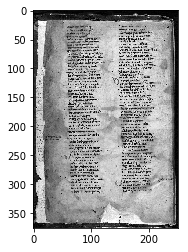

In [37]:
plt.imshow(image, interpolation='nearest', cmap = 'gray')
plt.show()

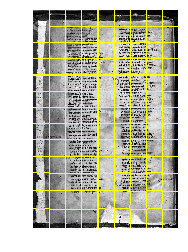

In [38]:
fig = plt.figure("Superpixels -- %d segments" % (500))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(image, segments))
plt.axis("off")
 
# show the plots
plt.show()

In [39]:
xy_append

[[(57.625, 27.75),
  (64.0, 27.0),
  (76.875, 26.375),
  (108.375, 26.5),
  (109.25, 31.125),
  (106.0, 32.25),
  (106.0, 37.25),
  (103.375, 45.625),
  (110.125, 46.0),
  (114.0, 51.625),
  (117.625, 52.0),
  (118.0, 56.625),
  (117.625, 57.5),
  (108.625, 58.25),
  (108.0, 61.25),
  (116.5, 61.25),
  (116.875, 71.0),
  (119.375, 71.375),
  (122.625, 77.25),
  (126.5, 82.25),
  (124.875, 84.125),
  (117.75, 84.125),
  (117.75, 88.125),
  (128.875, 88.625),
  (127.25, 92.875),
  (112.75, 94.875),
  (109.875, 100.375),
  (111.375, 108.5),
  (118.5, 109.5),
  (119.625, 111.5),
  (119.25, 119.25),
  (112.625, 121.375),
  (113.5, 124.375),
  (116.5, 129.375),
  (119.875, 131.375),
  (119.75, 137.25),
  (108.875, 138.0),
  (107.125, 151.0),
  (116.125, 151.875),
  (115.5, 158.25),
  (105.875, 158.25),
  (106.0, 162.375),
  (115.875, 164.25),
  (115.125, 171.875),
  (119.375, 173.0),
  (119.0, 178.625),
  (117.25, 180.625),
  (104.375, 180.5),
  (102.375, 181.125),
  (102.625, 184.5),
  (113

In [ ]:
len(range(0,total_columns-(2*k)+1,k))

In [ ]:
# Regions[20][14:14+k,28:28+k]
i = 20
plt.imshow(Regions[20][14:14+k,28:28+k], interpolation='nearest', cmap = 'gray')
plt.show()

In [ ]:
# input_images[20]
plt.imshow(input_images[20], interpolation='nearest', cmap = 'gray')
plt.show()

In [ ]:
all_coordinates[20]

In [ ]:
input_images[20]

In [ ]:
image[14:28,56:70]

In [ ]:
range(0,total_rows-(k)+1,k)

In [ ]:
total_rows

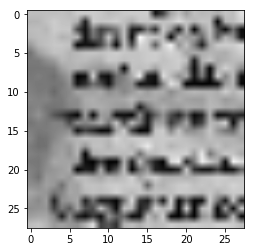

1


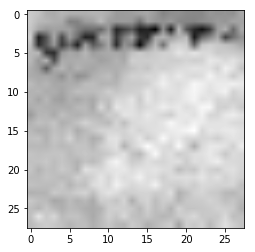

0


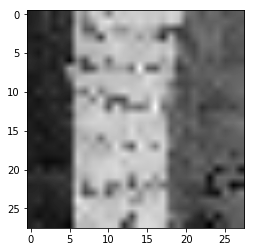

0


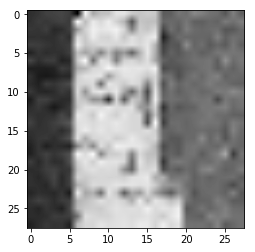

0


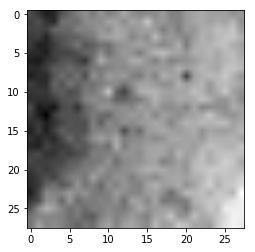

1


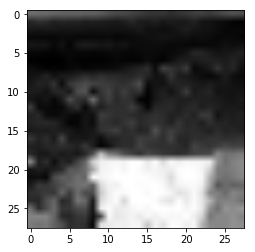

0


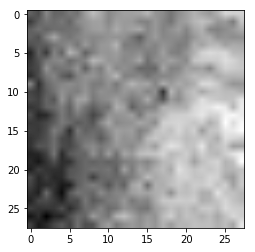

1


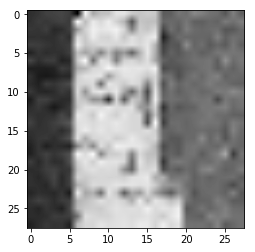

0


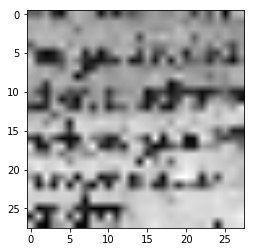

0


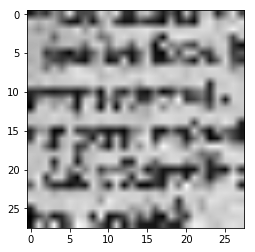

0


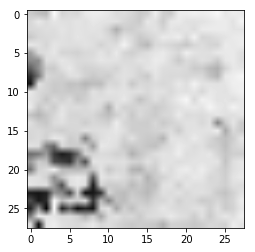

1


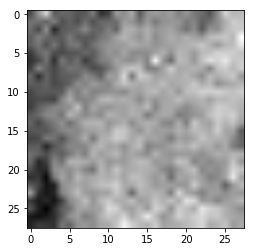

0


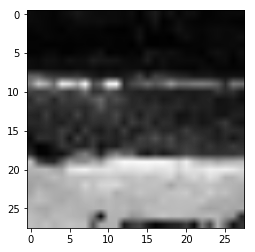

0


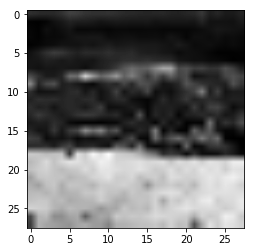

0


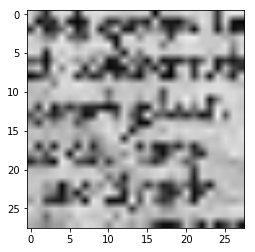

1


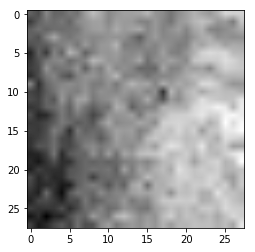

1


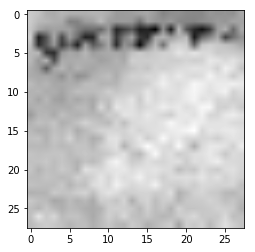

0


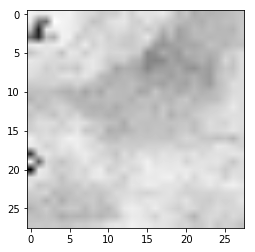

0


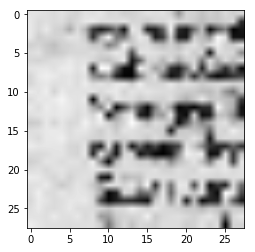

1


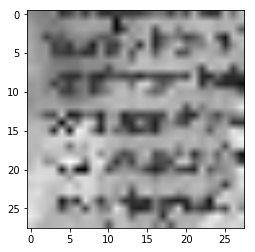

1


In [43]:
for i in np.random.choice(len(training_data), 20):
    plt.imshow(training_data[i][0], interpolation='bilinear', cmap = 'gray')
    plt.show()
    print(training_data[i][1])

In [ ]:
xy_append[0]